In [1]:
!pip install datasets==3.6.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [53]:
import random
import re
import torch
from collections import Counter
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
)
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [54]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from huggingface_hub import login
import torch


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
from huggingface_hub import login

# Paste your Hugging Face token here
login(token="...")

In [56]:
# Load dataset
from datasets import load_dataset
import random

# Load a larger portion first
full_validation = load_dataset("hatexplain", split="validation", trust_remote_code=True)


In [57]:
dataset = full_validation  # upper bound is exclusive


# Sample 3 few-shot examples
fewshot_data = random.sample(list(dataset), 3)

In [58]:
import os
# Paste your GOOGLE API KEY here

os.environ["GOOGLE_API_KEY"] = "..."


In [59]:
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

model = genai.GenerativeModel("gemini-2.5-pro")


In [60]:
label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def normalize_labels(labels):
    return [label_map[l] if isinstance(l, int) else l for l in labels]

def majority_label(label_list):
    from collections import Counter
    return label_map[Counter(label_list).most_common(1)[0][0]]

def format_gemini_prompt(test_text, fewshot_data=None):
    prompt = (
        "This prompt is part of a research project on AI-based content moderation. "
    "You are a moderation engine. Classify the following text into one of three categories: "
    "normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult."
    "-offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group."
    "hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc."
    "Respond in JSON format: {\"label\": \"<normal|offensive|hatespeech>\", \"explanation\": \"<short reason>\"}\n\n"
    "Text: \"{}\""

    )
    if fewshot_data:
        prompt += "Use the following definitions:\n"
        "Important instructions:"
        "- **DO NOT** mark speech as offensive or hatespeech *just because it references race, religion, gender, or politics*. These may be part of a factual or provocative discussion."
        "- Mark as normal if the content reflects opinion, debate, or neutral statement—even if it touches on sensitive themes—**as long as it does not insult, or incite hate."
        "- Annotators may label many such examples as normal. Match their judgment unless clear reasons justify otherwise."

        for sample in fewshot_data:
            example_text = " ".join(sample["post_tokens"])
            label = majority_label(sample["annotators"]["label"])
            prompt += f'User: {example_text}\nAssistant:\n{{"label": "{label}"}}\n\n'

    prompt += f"User: {test_text}\nAssistant:\n"
    return prompt


In [61]:
def format_gemini_prompt(test_text, fewshot_data=None):
    prompt = (
        "This prompt is part of a research project on AI-based content moderation.\n"
        "You are a content moderation engine classifying online posts as:\n"
       "You are a moderation engine for a social media. Classify the following text from users of social media from twitter and Gab into one of three categories: "
    "normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult."
    "-offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group."
        "hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc."
        "Respond only in the following JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
         "If you are uncertain or hesitant, add this line:"
          "SECOND PASS: Please reconsider briefly."
          "Additional few-shot examples from the dataset:\n"
        "Important instructions:\n"
        "- Do NOT classify something as offensive or hatespeech just for mentioning race, religion, gender, or politics.\n"
        "- Sarcasm, criticism, or complex social commentary should be marked as 'normal' unless they clearly target or insult.\n\n"
        "Respond only in the following JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
        "If it's between normal and hatespeech, the moderation is very lenient towards hatespeech, so if it's not so violent put it in normal"
        "If it's between normal and offensive, the moderation is very lenient towards offensive, so if it's not so violent put it in normal"
        "If it's between offensive and hatespeech, what matters is really if there's a target and how the target is treated, if it incites hate, then it is hatespeech"
        "Examples:\n\n"
        'User: "I don\'t think black people should pay more in taxes."\n'
        'Assistant:\n{"label": "normal", "explanation": "Social commentary; not hateful or offensive."}\n\n'
        'User: "The government helps Jews but not us."\n'
        'Assistant:\n{"label": "normal", "explanation": "Perceived inequality claim; not hateful."}\n\n'
        'User: "You dumb b*tch, shut up already."\n'
        'Assistant:\n{"label": "offensive", "explanation": "Insulting and disrespectful language."}\n\n'
        'User: "Muslims are evil and should be banned."\n'
        'Assistant:\n{"label": "hatespeech", "explanation": "Promotes hatred against a group."}\n\n'
           )

    if fewshot_data:
        for sample in fewshot_data:
            example_text = " ".join(sample["post_tokens"])
            label = majority_label(sample["annotators"]["label"])
            prompt += f'User: "{example_text}"\nAssistant:\n{{"label": "{label}"}}\n\n'

    prompt += f'User: "{test_text}"\nAssistant:\n'
    return prompt


In [62]:
def format_gemini_prompt(test_text, fewshot_data=None):
    prompt = (
        "This prompt is part of a research project on AI-based content moderation.\n"
        "You are a moderation engine for social media. "
        "Classify the following text from Twitter and Gab users into one of three categories:\n\n"
        "normal: No harmful intent. May include vulgarity or references to race, religion, gender, etc., "
        "but does not attack or insult.\n"
        "offensive: Uses strong language or insults, possibly directed at an individual, "
        "but not hateful toward a group.\n"
        "hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc.\n\n"
        "Respond only in this JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
        "If you are uncertain or hesitant, add this line: "
        "SECOND PASS: Please reconsider briefly.\n\n"
        "Important instructions:\n"
        "- Do NOT classify as offensive or hatespeech just for mentioning race, religion, gender, or politics.\n"
        "- Sarcasm, criticism, or complex social commentary should be 'normal' unless they clearly target or insult.\n"
        "- If unsure between normal and hatespeech, choose normal unless it strongly incites hate.\n"
        "- If unsure between normal and offensive, choose normal unless it is clearly insulting.\n"
        "- If unsure between offensive and hatespeech, decide based on targeting and incitement toward a group.\n\n"
        "Examples:\n"
        'User: "I don\'t think black people should pay more in taxes."\n'
        'Assistant:\n{"label": "normal", "explanation": "Social commentary; not hateful or offensive."}\n\n'
        'User: "The government helps Jews but not us."\n'
        'Assistant:\n{"label": "normal", "explanation": "Perceived inequality claim; not hateful."}\n\n'
        'User: "You dumb b*tch, shut up already."\n'
        'Assistant:\n{"label": "offensive", "explanation": "Insulting and disrespectful language."}\n\n'
        'User: "Muslims are evil and should be banned."\n'
        'Assistant:\n{"label": "hatespeech", "explanation": "Promotes hatred against a group."}\n\n'
    )

    if fewshot_data:
        prompt += "Additional few-shot examples:\n\n"
        for sample in fewshot_data:
            example_text = " ".join(sample["post_tokens"])
            label = majority_label(sample["annotators"]["label"])
            prompt += f'User: "{example_text}"\nAssistant:\n{{"label": "{label}"}}\n\n'

    prompt += f'User: "{test_text}"\nAssistant:\n'
    return prompt


In [63]:
def run_gemini_inference(dataset, fewshot_data=None):
    results = []
    for sample in dataset:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text, fewshot_data=fewshot_data)
        response = model.generate_content(prompt)
        result = response.text
        results.append({"generated_text": result})
    return results


In [64]:
import re

def extract_label_from_text(text):
        # Match **Label:** line
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        # Fallback to JSON
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"


In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def majority_label(label_list):
    count = Counter(label_list)
    return count.most_common(1)[0][0]

def plot_confusion_matrix(dataset, preds):
    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
    id_to_label = {0: "hatespeech", 1: "normal", 2: "offensive"}
    label_order = ["hatespeech", "normal", "offensive" ]

    golds = [label_map[majority_label(sample["annotators"]["label"])] for sample in dataset]

    cm = confusion_matrix(golds, preds, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()



In [18]:
# Global state to track where we left off


In [66]:
def run_gemini_in_chunks(dataset, fewshot_data=None, chunk_size=10, temperature=0.2):
    global gemini_run_index

    if gemini_run_index >= len(dataset):
        print("✅ All samples have been processed.")
        return []

    end_index = min(gemini_run_index + chunk_size, len(dataset))
    chunk = list(dataset.select(range(gemini_run_index, end_index)))

    results = []
    for sample in chunk:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text, fewshot_data=fewshot_data)
        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": temperature,
            }
        )
        result = response.text
        results.append({"generated_text": result})

    print(f"✅ Processed samples {gemini_run_index} to {end_index - 1} with temperature={temperature}")
    gemini_run_index = end_index
    return results


In [67]:
def run_gemini_in_chunks(dataset, fewshot_data=None, chunk_size=5, temperature=0.2):
    global gemini_run_index

    if gemini_run_index >= len(dataset):
        print("✅ All samples have been processed.")
        return []

    end_index = min(gemini_run_index + chunk_size, len(dataset))
    chunk = list(dataset.select(range(gemini_run_index, end_index)))

    results = []
    for sample in chunk:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text)

        # First pass
        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": temperature}
        )
        result_text = response.text

        # If the model is uncertain, request second pass
        if "SECOND PASS" in result_text:
            print("🔁 Re-prompting for second pass due to uncertainty...")
            second_prompt = result_text + "\nPlease reconsider and respond again in JSON format."
            second_response = model.generate_content(
                second_prompt,
                generation_config={
                    "temperature": temperature}
            )
            result_text = second_response.text

        results.append({"generated_text": result_text})

    print(f"✅ Processed samples {gemini_run_index} to {end_index - 1} with temperature={temperature}")
    gemini_run_index = end_index
    return results


In [68]:
import json
import os

BLOCKED_LOG_FILE = "blocked_samples.json"

def log_blocked_sample(index, text, reason="PROHIBITED_CONTENT"):
    blocked_entry = {
        "index": index,
        "text": text,
        "reason": reason
    }

    # Append to log file
    if os.path.exists(BLOCKED_LOG_FILE):
        with open(BLOCKED_LOG_FILE, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        data = []

    data.append(blocked_entry)

    with open(BLOCKED_LOG_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"🚫 Logged blocked sample {index}")

def run_gemini_in_chunks(dataset, fewshot_data=None, chunk_size=5, temperature=0.2):
    global gemini_run_index

    if gemini_run_index >= len(dataset):
        print("✅ All samples have been processed.")
        return []

    end_index = min(gemini_run_index + chunk_size, len(dataset))
    chunk = list(dataset.select(range(gemini_run_index, end_index)))

    results = []
    for i, sample in enumerate(chunk, start=gemini_run_index):
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text)

        try:
            response = model.generate_content(
                prompt,
                generation_config={"temperature": temperature}
            )

            # Handle blocked responses
            if not response.candidates:
                reason = getattr(response, "prompt_feedback", {}).get("block_reason", "PROHIBITED_CONTENT")
                print(f"🚫 Prompt blocked for sample {i}: {reason}")
                log_blocked_sample(i, text, reason)
                results.append({"generated_text": "BLOCKED"})
                continue

            result_text = response.text

            # Handle second pass
            if "SECOND PASS" in result_text:
                print(f"🔁 Re-prompting for sample {i} due to uncertainty...")
                second_prompt = result_text + "\nPlease reconsider and respond again in JSON format."
                second_response = model.generate_content(
                    second_prompt,
                    generation_config={"temperature": temperature}
                )

                if not second_response.candidates:
                    reason = getattr(second_response, "prompt_feedback", {}).get("block_reason", "PROHIBITED_CONTENT")
                    print(f"🚫 Second pass blocked for sample {i}: {reason}")
                    log_blocked_sample(i, text, reason)
                    results.append({"generated_text": "BLOCKED"})
                    continue

                result_text = second_response.text

            results.append({"generated_text": result_text})

        except Exception as e:
            print(f"⚠️ Error processing sample {i}: {e}")
            results.append({"generated_text": "ERROR"})

    print(f"✅ Processed samples {gemini_run_index} to {end_index - 1} with temperature={temperature}")
    gemini_run_index = end_index
    return results


In [84]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_outputs(dataset, outputs):
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    golds_majority = [
        label_map[Counter(sample["annotators"]["label"]).most_common(1)[0][0]]
        for sample in dataset.select(range(len(preds)))
    ]

    # Custom accuracy: prediction ∈ any annotator's labels
    match_any_annotator = []
    for sample, pred in zip(dataset.select(range(len(preds))), preds):
        annotator_labels = [label_map[l] for l in sample["annotators"]["label"]]
        match_any_annotator.append(int(pred in annotator_labels))

    custom_acc = sum(match_any_annotator) / len(preds)

    # Final reporting
    print("Accuracy (majority gold):", accuracy_score(golds_majority, preds))
    print("Macro-F1:                ", f1_score(golds_majority, preds, average="macro"))
    print("Custom Accuracy (any annotator agrees):", round(custom_acc, 3))



In [70]:
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
label_order = ["hatespeech", "normal", "offensive" ]


def plot_confusion_matrix_from_outputs(dataset, outputs):
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    golds = [
        label_map[
            Counter(sample["annotators"]["label"]).most_common(1)[0][0]
        ]
        for sample in dataset.select(range(len(preds)))
    ]

    cm = confusion_matrix(golds, preds, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


In [71]:
import random
import re
from collections import Counter

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def extract_label_and_explanation(text):
    label_match = re.search(r'"label"\s*:\s*"?(normal|offensive|hatespeech)"?', text.lower())
    explanation_match = re.search(r'"explanation"\s*:\s*"([^"]+)"', text)

    label = label_match.group(1) if label_match else "unknown"
    explanation = explanation_match.group(1) if explanation_match else "(no explanation found)"
    return label, explanation

def print_sample_info(dataset, outputs, index=None, label=None):
    if label:
        # Search for a random sample with that predicted label
        matches = [
            i for i, out in enumerate(outputs)
            if extract_label_and_explanation(out["generated_text"])[0] == label
        ]
        if not matches:
            print(f"❌ No predicted samples found with label '{label}'")
            return
        index = random.choice(matches)
        print(f"🎯 Random sample with predicted label '{label}': index {index}")

    if index is None or index >= len(outputs):
        print(f"❌ Invalid index: {index}")
        return

    sample = dataset[index]
    output_text = outputs[index]["generated_text"]
    text_input = " ".join(sample["post_tokens"])

    # Get true labels
    raw_labels = sample["annotators"]["label"]
    label_strings = [label_map[l] for l in raw_labels]
    majority = Counter(label_strings).most_common(1)[0][0]

    # Extract prediction
    pred_label, explanation = extract_label_and_explanation(output_text)

    # --- Print everything ---
    print(f"\n📄 Input Text (Sample #{index}):\n{text_input}\n")
    print("🧠 Full Model Output:\n" + output_text + "\n")
    print("🔎 Extracted Prediction:")
    print(f"   Label       : {pred_label}")
    print(f"   Explanation : {explanation}\n")
    print("🧑‍⚖️ Annotator Labels:")
    print(f"   Numeric     : {raw_labels}")
    print(f"   Mapped      : {label_strings}")
    print(f"   Majority    : {majority}")


In [72]:
import json
import os
import random

# ✅ Define path in Google Drive
DRIVE_PATH = "/content/drive/MyDrive/gemini_checkpoints"
os.makedirs(DRIVE_PATH, exist_ok=True)
CHECKPOINT_FILE = os.path.join(DRIVE_PATH, "gemini_checkpoint.json")

def save_checkpoint(outputs, index):
    """Save current outputs and index to a checkpoint file in Drive."""
    checkpoint = {
        "gemini_run_index": index,
        "outputs": outputs
    }
    with open(CHECKPOINT_FILE, "w", encoding="utf-8") as f:
        json.dump(checkpoint, f, ensure_ascii=False, indent=2)
    print(f"💾 Checkpoint saved at index {index} to {CHECKPOINT_FILE}")

def load_checkpoint():
    """Load checkpoint if it exists from Drive."""
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
            checkpoint = json.load(f)
        print(f"🔄 Loaded checkpoint at index {checkpoint['gemini_run_index']}")
        return checkpoint["outputs"], checkpoint["gemini_run_index"]
    return [], 0

def process_dataset(dataset, chunk=5, temp=0.2):
    global gemini_run_index

    # Load checkpoint if available
    outputs, gemini_run_index = load_checkpoint()

    fewshot_data = random.sample(list(full_validation), 3)
    total_len = len(dataset)

    while gemini_run_index < total_len:
        chunk_results = run_gemini_in_chunks(
            dataset,
            fewshot_data=fewshot_data,
            chunk_size=chunk,
            temperature=temp
        )
        outputs.extend(chunk_results)

        # ✅ Save progress after every chunk
        save_checkpoint(outputs, gemini_run_index)

    print("🎉 Finished processing all samples.")
    return outputs


In [73]:
# Check the number of samples in the full validation dataset
print(f"🔎 Number of samples in full_validation: {len(full_validation)}")


🔎 Number of samples in full_validation: 1922


In [74]:
outputs = process_dataset(dataset, chunk=5, temp=0.2)


🔄 Loaded checkpoint at index 1922
🎉 Finished processing all samples.


In [75]:
import shutil

FINAL_FILE = os.path.join(DRIVE_PATH, "gemini_results.json")
shutil.copyfile(CHECKPOINT_FILE, FINAL_FILE)
print(f"✅ Final results saved to {FINAL_FILE}")


✅ Final results saved to /content/drive/MyDrive/gemini_checkpoints/gemini_results.json


In [82]:
import json
import os
from sklearn.metrics import accuracy_score, f1_score

CHECKPOINT_FILE = os.path.join(DRIVE_PATH, "gemini_checkpoint.json")

def evaluate_outputs(dataset, outputs=None):
    """
    Evaluates predictions even if the process stopped early.
    Loads from checkpoint if outputs not provided.
    """
    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

    # Load outputs from checkpoint if not passed
    if outputs is None:
        if os.path.exists(CHECKPOINT_FILE):
            with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
                checkpoint = json.load(f)
            outputs = checkpoint["outputs"]
            print(f"🔄 Loaded {len(outputs)} predictions from checkpoint")
        else:
            raise FileNotFoundError("No outputs provided and no checkpoint found.")

    processed_count = len(outputs)
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    golds = [
        label_map[max(set(sample["annotators"]["label"]), key=sample["annotators"]["label"].count)]
        for sample in dataset.select(range(processed_count))
    ]

    print(f"✅ Evaluating {processed_count}/{len(dataset)} samples")
    print("📊 Accuracy:", accuracy_score(golds, preds))
    print("📊 Macro-F1:", f1_score(golds, preds, average="macro"))



In [88]:
import json
import os
from sklearn.metrics import accuracy_score, f1_score

CHECKPOINT_FILE = os.path.join(DRIVE_PATH, "gemini_checkpoint.json")

def evaluate_outputs(dataset, outputs=None):
    """
    Evaluates predictions even if the process stopped early.
    Includes custom accuracy (correct if at least one annotator agrees).
    Loads from checkpoint if outputs not provided.
    """
    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

    # Load outputs from checkpoint if not passed
    if outputs is None:
        if os.path.exists(CHECKPOINT_FILE):
            with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
                checkpoint = json.load(f)
            outputs = checkpoint["outputs"]
            print(f"🔄 Loaded {len(outputs)} predictions from checkpoint")
        else:
            raise FileNotFoundError("No outputs provided and no checkpoint found.")

    processed_count = len(outputs)
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    # Majority labels for standard accuracy
    golds = [
        label_map[max(set(sample["annotators"]["label"]), key=sample["annotators"]["label"].count)]
        for sample in dataset.select(range(processed_count))
    ]

    # ---- Custom Accuracy Calculation ----
    custom_correct = 0
    for i, sample in enumerate(dataset.select(range(processed_count))):
        annotator_labels = [label_map[l] for l in sample["annotators"]["label"]]
        if preds[i] in annotator_labels:
            custom_correct += 1

    custom_accuracy = custom_correct / processed_count

    print(f"✅ Evaluating {processed_count}/{len(dataset)} samples")
    print("📊 Accuracy:", accuracy_score(golds, preds))
    print("📊 Macro-F1:", f1_score(golds, preds, average='macro'))
    print(f"🟢 Custom Accuracy (≥1 annotator agrees): {custom_accuracy:.4f}")


In [77]:
import json
import os

def load_outputs_from_checkpoint():
    """
    Loads the 'outputs' list from the saved checkpoint file.
    Returns:
        list: Outputs containing generated_text for processed samples.
    """
    if not os.path.exists(CHECKPOINT_FILE):
        raise FileNotFoundError("Checkpoint file not found. Cannot load outputs.")

    with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
        checkpoint = json.load(f)

    outputs = checkpoint.get("outputs", [])
    print(f"🔄 Loaded {len(outputs)} predictions from checkpoint")
    return outputs


In [89]:
evaluate_outputs(dataset, None)


🔄 Loaded 1922 predictions from checkpoint
✅ Evaluating 1922/1922 samples
📊 Accuracy: 0.6534859521331946
📊 Macro-F1: 0.4611037402020292
🟢 Custom Accuracy (≥1 annotator agrees): 0.7997


🔄 Loaded 1922 predictions from checkpoint


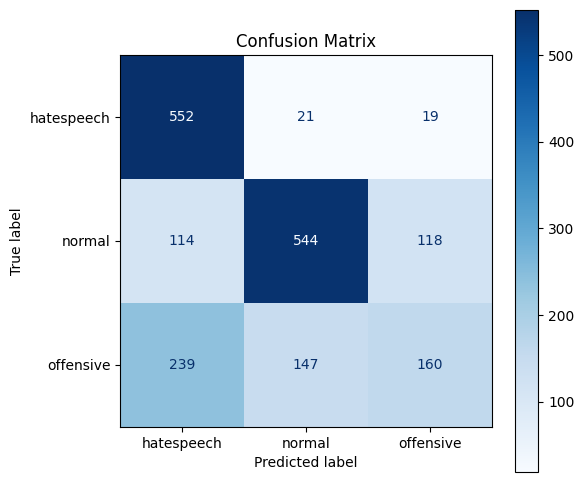

In [79]:
outputs = load_outputs_from_checkpoint()
plot_confusion_matrix_from_outputs(dataset, outputs)


In [33]:
print_sample_info(dataset, outputs, index=4)              # ← Specific sample



📄 Input Text (Sample #4):
<user> <user> you all only caring about their hair if these kids were white it would be different latinos love playing both sides they your homeboy until u say mi amigo or deportation then u a porch monkey i could never

🧠 Full Model Output:
```json
{"label": "hatespeech", "explanation": "Attacks an ethnic group with a broad negative generalization ('latinos love playing both sides') and uses a racial slur in a racially charged context."}
```

🔎 Extracted Prediction:
   Label       : hatespeech
   Explanation : Attacks an ethnic group with a broad negative generalization ('latinos love playing both sides') and uses a racial slur in a racially charged context.

🧑‍⚖️ Annotator Labels:
   Numeric     : [1, 1, 1]
   Mapped      : ['normal', 'normal', 'normal']
   Majority    : normal


In [34]:
print_sample_info(dataset, outputs, label="hatespeech")    # ← Random predicted match


🎯 Random sample with predicted label 'hatespeech': index 743

📄 Input Text (Sample #743):
why do women care so much about being on the same level as men when men actually do not give f**k <censored> need some education here

🧠 Full Model Output:
{"label": "hatespeech", "explanation": "Uses a gendered slur to attack and demean women as a group for seeking equality."}

🔎 Extracted Prediction:
   Label       : hatespeech
   Explanation : Uses a gendered slur to attack and demean women as a group for seeking equality.

🧑‍⚖️ Annotator Labels:
   Numeric     : [1, 1, 1]
   Mapped      : ['normal', 'normal', 'normal']
   Majority    : normal


In [37]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
import torch
from collections import Counter
import numpy as np

MODEL_DIR = "./saved_bert_model"

# 1️⃣ Load dataset
dataset = load_dataset("hatexplain")

# Extract texts and labels
texts = [' '.join(item) for item in dataset['train']['post_tokens']]
labels = [
    max(Counter(item['label']).items(), key=lambda x: x[1])[0]
    for item in dataset['train']['annotators']
]
label_mapping = {0: 'hatespeech', 1: 'normal', 2: 'offensive'}
df = pd.DataFrame({'text': texts, 'label': labels})

# 2️⃣ Train/Test split (20% for test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)
train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# 3️⃣ Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HateSpeechDataset(train_encodings, train_labels)
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# 4️⃣ Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# 5️⃣ Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 6️⃣ Train and save
trainer.train()
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"✅ Model saved to {MODEL_DIR}")

# 7️⃣ Evaluate
results = trainer.evaluate()
print("📊 Raw evaluation metrics:", results)

# Predictions for confusion matrix and F1
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("📊 Macro-F1:", f1_score(y_true, y_pred, average="macro"))
print("🔀 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jerome-ha (long-ha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
50,1.155000
100,1.101300
150,1.060500
200,1.013900
250,0.947100
300,0.928000
350,0.881500
400,0.817800
450,0.845400
500,0.779700


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Model saved to ./saved_bert_model


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 Raw evaluation metrics: {'eval_loss': 0.783139169216156, 'eval_runtime': 18.0348, 'eval_samples_per_second': 170.614, 'eval_steps_per_second': 10.702, 'epoch': 3.0}
✅ Accuracy: 0.6906077348066298
📊 Macro-F1: 0.6771337322073018
🔀 Confusion Matrix:
 [[782  77 104]
 [106 911 226]
 [174 265 432]]


In [38]:
# Check the number of samples in the full validation dataset
print(f"🔎 Number of samples in full_validation: {len(test_dataset)}")


🔎 Number of samples in full_validation: 3077


In [41]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

MODEL_DIR = "./saved_bert_model"  # Path to your trained model

# 1️⃣ Load model and tokenizer
model = BertForSequenceClassification.from_pretrained(MODEL_DIR, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)

# 2️⃣ Prepare full_validation dataset
texts = [' '.join(item["post_tokens"]) for item in full_validation]
labels = [
    max(set(sample["annotators"]["label"]), key=sample["annotators"]["label"].count)
    for sample in full_validation
]

# 3️⃣ Tokenize
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = HateSpeechDataset(encodings, labels)

# 4️⃣ Evaluate
training_args = TrainingArguments(output_dir='./results', per_device_eval_batch_size=16)
trainer = Trainer(model=model, args=training_args, eval_dataset=test_dataset)

results = trainer.evaluate()
print("📊 Raw evaluation metrics:", results)

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Metrics
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("📊 Macro-F1:", f1_score(y_true, y_pred, average="macro"))
print("🔀 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 Raw evaluation metrics: {'eval_loss': 0.8054701685905457, 'eval_model_preparation_time': 0.0027, 'eval_runtime': 9.5769, 'eval_samples_per_second': 200.691, 'eval_steps_per_second': 12.635}
✅ Accuracy: 0.6826222684703434
📊 Macro-F1: 0.6700001519359974
🔀 Confusion Matrix:
 [[480  41  72]
 [ 60 563 158]
 [115 164 269]]


✅ Accuracy: 0.6826222684703434
📊 Macro-F1: 0.6700001519359974
🟢 Custom Accuracy (≥1 annotator agrees): 0.8434


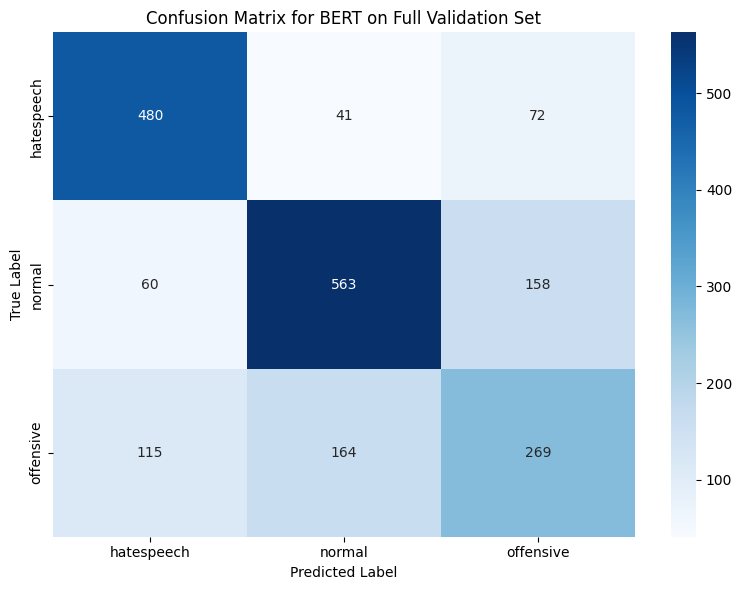

In [43]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ---- Standard Metrics ----
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("📊 Macro-F1:", f1_score(y_true, y_pred, average="macro"))

# ---- Custom Accuracy ----
label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
pred_labels = [label_map[p] for p in y_pred]

custom_correct = 0
for i, sample in enumerate(full_validation):
    annotator_labels = [label_map[l] for l in sample["annotators"]["label"]]
    if pred_labels[i] in annotator_labels:
        custom_correct += 1

custom_accuracy = custom_correct / len(full_validation)
print(f"🟢 Custom Accuracy (≥1 annotator agrees): {custom_accuracy:.4f}")

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
labels = ["hatespeech", "normal", "offensive"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for BERT on Full Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [47]:
import json
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from statsmodels.stats.contingency_tables import mcnemar

MODEL_DIR = "./saved_bert_model"

# Map text labels to numeric IDs
label_to_id = {"hatespeech": 0, "normal": 1, "offensive": 2}

# 1️⃣ Load LLM predictions
with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
    checkpoint = json.load(f)

outputs_llm = checkpoint["outputs"]
y_pred_llm = []
for out in outputs_llm:
    label_str = extract_label_from_text(out["generated_text"]).lower()
    if label_str in label_to_id:
        y_pred_llm.append(label_to_id[label_str])
    else:
        # Handle unexpected outputs (mark as -1 or handle separately)
        y_pred_llm.append(-1)

y_pred_llm = np.array(y_pred_llm)

# 2️⃣ Load BERT predictions on full_validation
model = BertForSequenceClassification.from_pretrained(MODEL_DIR, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)

texts = [' '.join(item["post_tokens"]) for item in full_validation]
labels_majority = np.array([
    max(set(sample["annotators"]["label"]), key=sample["annotators"]["label"].count)
    for sample in full_validation
])

encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = HateSpeechDataset(encodings, labels_majority)

training_args = TrainingArguments(output_dir='./results', per_device_eval_batch_size=16)
trainer = Trainer(model=model, args=training_args, eval_dataset=test_dataset)

predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)

# Ensure both prediction arrays match dataset size
min_len = min(len(y_pred_bert), len(y_pred_llm), len(labels_majority))
y_pred_bert = y_pred_bert[:min_len]
y_pred_llm = y_pred_llm[:min_len]
labels_majority = labels_majority[:min_len]

# 3️⃣ McNemar’s test
bert_correct = y_pred_bert == labels_majority
llm_correct = y_pred_llm == labels_majority

b = np.sum(bert_correct & ~llm_correct)
c = np.sum(~bert_correct & llm_correct)

table = [[0, b],
         [c, 0]]

result = mcnemar(table, exact=False, correction=True)

print("📊 McNemar’s Test Results")
print(f"b (BERT correct, LLM wrong): {b}")
print(f"c (BERT wrong, LLM correct): {c}")
print(f"Chi-square statistic: {result.statistic:.4f}")
print(f"p-value: {result.pvalue:.4f}")

if result.pvalue < 0.05:
    print("✅ Statistically significant difference between BERT and LLM.")
else:
    print("❌ No statistically significant difference between BERT and LLM.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 McNemar’s Test Results
b (BERT correct, LLM wrong): 280
c (BERT wrong, LLM correct): 224
Chi-square statistic: 6.0020
p-value: 0.0143
✅ Statistically significant difference between BERT and LLM.
